In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from bluerecording.writeH5 import getSegmentMidpts,sort_electrode_names, getArraySpacing
%matplotlib ipympl

In [15]:
fname = 'csd_paper/electrodes/derivative.h5'

In [16]:
f = h5py.File(fname)

In [17]:
f['S1nonbarrel_neurons'].keys()

<KeysViewHDF5 ['node_ids', 'offsets']>

In [18]:
f['electrodes']['S1nonbarrel_neurons']['scaling_factors']

<HDF5 dataset "scaling_factors": shape (78575193, 99), type "<f8">

In [19]:
for dirpath, dirnames, filenames in os.walk('csd_paper/electrodes/positions'):
        for filename in filenames[:1]:
            file_path = os.path.join(dirpath, filename)
            positions = pd.read_pickle(file_path)

In [20]:
pos = pd.read_pickle(file_path)

In [21]:
node_ids = np.unique(np.array(list(pos.columns))[:,0])

In [22]:
import time 

In [23]:
t = time.time()
newPos = getSegmentMidpts(pos[node_ids[0:2]],node_ids[0:2])
print(time.time()-t)

/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)


0.5387978553771973


In [24]:
originalFile = h5py.File('csd_paper/electrodes/coeffs_highRes.h5')
electrodeNames = sort_electrode_names(originalFile['electrodes'].keys(),'S1nonbarrel_neurons')
allEpos = []
for e in electrodeNames:
    allEpos.append( originalFile['electrodes'][str(e)]['position'][:] )
allEpos = np.array(allEpos)
originalFile.close()

In [25]:
allEpos = allEpos[1:-1]

In [26]:
main_axis, arraySpacing = getArraySpacing(allEpos)

In [27]:
def distances_in_planar_coords(compartment_positions, electrodePos, main_axis):

    '''
    For a disk or plane perpendicular to main_axis, returns the axial and radial coordinates of each of the compartment positions
    '''

    from bluerecording.writeH5 import calculate_axial_vectors

    ### Projects compartment positions onto plane, containing the point electrodePos, normal to electrode array
    differenceVectors = compartment_positions.values - electrodePos[:,np.newaxis]

    axialDistances = np.matmul(differenceVectors.T,main_axis) # Size len(compartment_positions)x1

    #axialVectors = calculate_axial_vectors(axialDistances,main_axis) # Projection of diffence vector onto the main axis of the electrode array


    return axialDistances

In [28]:
distances_in_planar_coords(newPos[node_ids[0]],allEpos[1],main_axis).shape

(483, 1)

In [29]:
import bluepysnap as bp

In [30]:
c = bp.Simulation('/work/lnmc/EEG/original/fixed/a9f782a3-1f22-4384-a122-430bc6b2323c/0/simulation_config.json')

In [31]:
hex0 = next(c.circuit.nodes.get('hex0',properties=['mtype']))

In [32]:
hex0Ids = np.array(hex0[1].loc['S1nonbarrel_neurons'].index)

In [33]:
np.arange(10,100,10)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [ ]:


electrodeIndices = [10,25,50,75,90]
allDistances = []
allCsdCoeffs = []

for electrodeIdx in electrodeIndices:
    csdCoeffs = []
    distances = []

    numFiles = 0

    for dirpath, dirnames, filenames in os.walk('csd_paper/electrodes/positions'):
            for filename in filenames:
                
                file_path = os.path.join(dirpath, filename)
                positions = pd.read_pickle(file_path)
                
                node_ids = np.unique(np.array(list(positions.columns))[:,0])

                node_ids = node_ids[np.isin(node_ids,hex0Ids)]

                newNodeIds = node_ids

                newPos = getSegmentMidpts(positions[newNodeIds],newNodeIds)
    
                for ids in newNodeIds:
    
                    nodeIndex = np.where(f['S1nonbarrel_neurons']['node_ids']==ids)[0][0]
    
                    offset = f['S1nonbarrel_neurons']['offsets'][nodeIndex]
                    offset1 = f['S1nonbarrel_neurons']['offsets'][nodeIndex+1]
                    
                    distances.append(distances_in_planar_coords(newPos[ids],allEpos[electrodeIdx],main_axis))
                    
                    csdCoeffs.append(f['electrodes']['S1nonbarrel_neurons']['scaling_factors'][offset:offset1,electrodeIdx])   

    print(electrodeIdx)

    allCsdCoeffs.append(csdCoeffs)
    allDistances.append(distances)
    
            

/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=F

10


/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=F

25


/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=F

50


/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=F

In [82]:
len(distances)

212

In [83]:
len(csdCoeffs)

212

In [84]:
len(distances[0])

101

In [85]:
len(csdCoeffs[0])

101

In [55]:
distances = allDistances[1]
csdCoeffs = allCsdCoeffs[1]

In [56]:
distances = np.array(distances)
csdCoeffs = np.array(csdCoeffs)

In [57]:
newDistances = distances[0]
for d in distances[1:]:
    newDistances = np.vstack((newDistances,d))

In [58]:
newcoeffs = csdCoeffs[0][:,np.newaxis]
for c in csdCoeffs[1:]:
    newcoeffs = np.vstack((newcoeffs,c[:,np.newaxis]))

In [59]:
csdCoeffs.shape

(1493,)

In [60]:
distances.shape

(1493,)

In [61]:
newcoeffs.shape

(559351, 1)

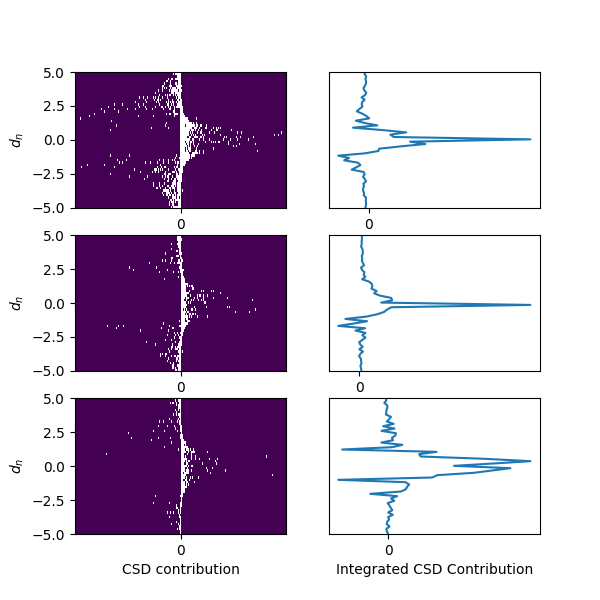

In [4]:
plt.figure(figsize=(6,6))

for i in range(3):
    
    distances = allDistances[i]
    csdCoeffs = allCsdCoeffs[i]
    
    distances = np.array(distances)
    csdCoeffs = np.array(csdCoeffs)

    newDistances = distances[0]
    for d in distances[1:]:
        newDistances = np.vstack((newDistances,d))
    
    newcoeffs = csdCoeffs[0][:,np.newaxis]
    for c in csdCoeffs[1:]:
        newcoeffs = np.vstack((newcoeffs,c[:,np.newaxis]))

    if i == 0:
        plotIdx = [1,2]
    elif i == 1:
        plotIdx = [3,4]
    elif i == 2:
        plotIdx = [5,6]

    plt.subplot(3,2,plotIdx[0])

    plt.hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=0.5)
    if i == 2:
        plt.xlabel('CSD contribution')
    plt.xticks([0])
    plt.xlim([-2e-6,2e-6])

    plt.ylabel('$d_n$')
    plt.ylim([-5,5])

    plt.subplot(3,2,plotIdx[1])

    hist, xbins, ybins = np.histogram2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000])
    xvals = (xbins[1:]+xbins[:-1])/2
    yvals = (ybins[1:]+ybins[:-1])/2

    plt.plot(np.sum(hist*xvals[:,np.newaxis],axis=0),yvals)
    plt.ylim([-5,5])

    if i == 2:
        plt.xlabel('Integrated CSD Contribution')
    plt.xticks([0])
    plt.yticks([])

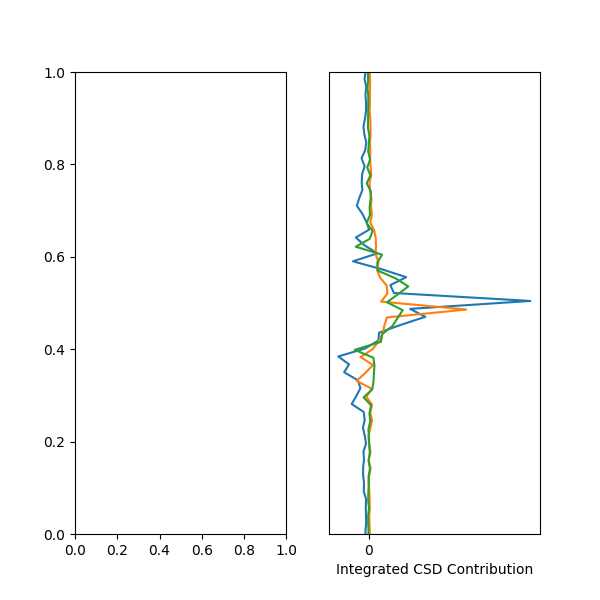

In [6]:
plt.figure(figsize=(6,6))

for i in range(3):
    
    distances = allDistances[i]
    csdCoeffs = allCsdCoeffs[i]
    
    distances = np.array(distances)
    csdCoeffs = np.array(csdCoeffs)

    newDistances = distances[0]
    for d in distances[1:]:
        newDistances = np.vstack((newDistances,d))
    
    newcoeffs = csdCoeffs[0][:,np.newaxis]
    for c in csdCoeffs[1:]:
        newcoeffs = np.vstack((newcoeffs,c[:,np.newaxis]))

    plotIdx = [1,2]

    plt.subplot(1,2,plotIdx[0])

    # plt.hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=0.5)
    # if i == 2:
    #     plt.xlabel('CSD contribution')
    # plt.xticks([0])
    # plt.xlim([-2e-6,2e-6])

    # plt.ylabel('$d_n$')
    # plt.ylim([-5,5])

    plt.subplot(1,2,plotIdx[1])

    hist, xbins, ybins = np.histogram2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000])
    xvals = (xbins[1:]+xbins[:-1])/2
    yvals = (ybins[1:]+ybins[:-1])/2

    plt.plot(np.sum(hist*xvals[:,np.newaxis],axis=0),yvals)
    plt.ylim([-5,5])

    if i == 2:
        plt.xlabel('Integrated CSD Contribution')
    plt.xticks([0])
    plt.yticks([])

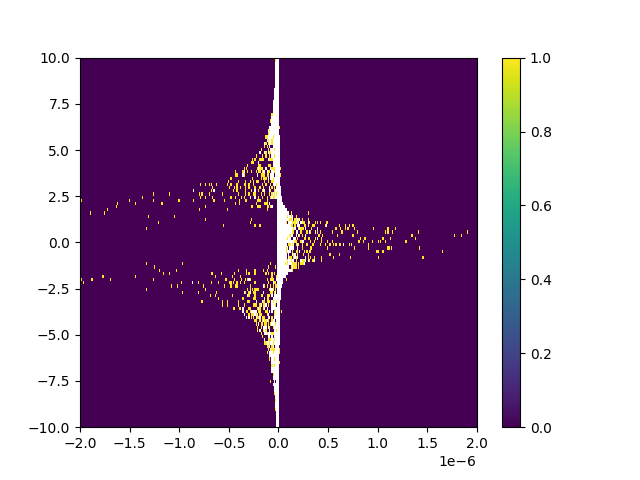

In [32]:
plt.figure()
plt.hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=1)
plt.xlim([-2e-6,2e-6])
plt.ylim([-10,10])
plt.colorbar()

In [33]:
hist, xbins, ybins = np.histogram2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000])

In [39]:
len(newcoeffs)/f['electrodes']['S1nonbarrel_neurons']['scaling_factors'].shape[0]/7

0.0010169530950345322

In [43]:
1493/30000

0.04976666666666667

In [35]:
xvals = (xbins[1:]+xbins[:-1])/2

In [36]:
yvals = (ybins[1:]+ybins[:-1])/2

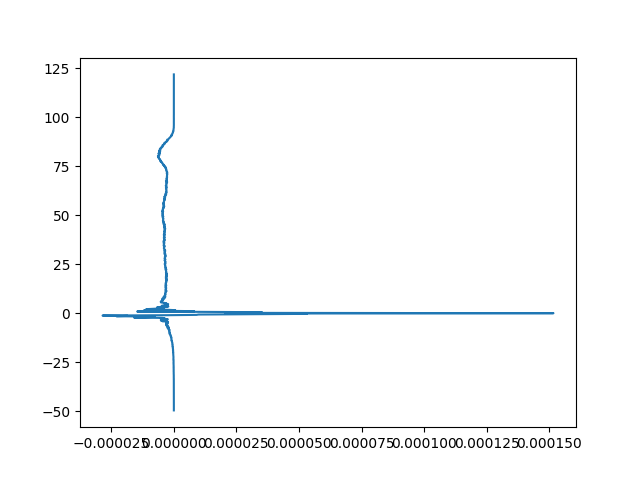

In [37]:
plt.figure()
plt.plot(np.sum(hist*xvals[:,np.newaxis],axis=0),yvals)

In [ ]:
np.save('allCoeffs.npy',allCsdCoeffs)
np.save('allDistances.npy',allDistances)

In [2]:
allCsdCoeffs = np.load('allCoeffs.npy',allow_pickle=True)
allDistances = np.load('allDistances.npy',allow_pickle=True)

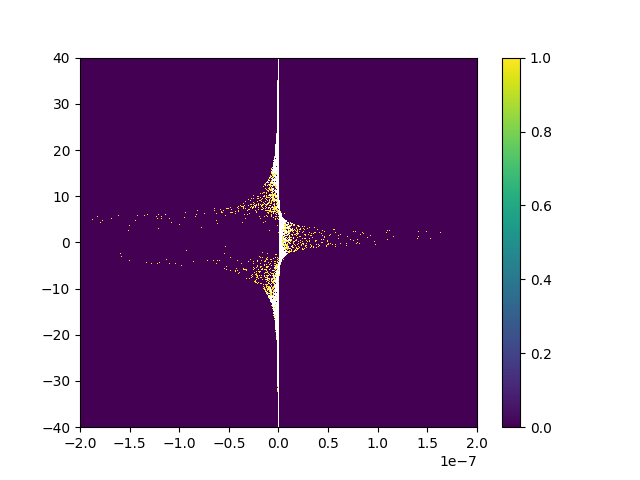

In [45]:
plt.figure()
plt.hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=1)
plt.xlim([-2e-7,2e-7])
plt.ylim([-40,40])
plt.colorbar()

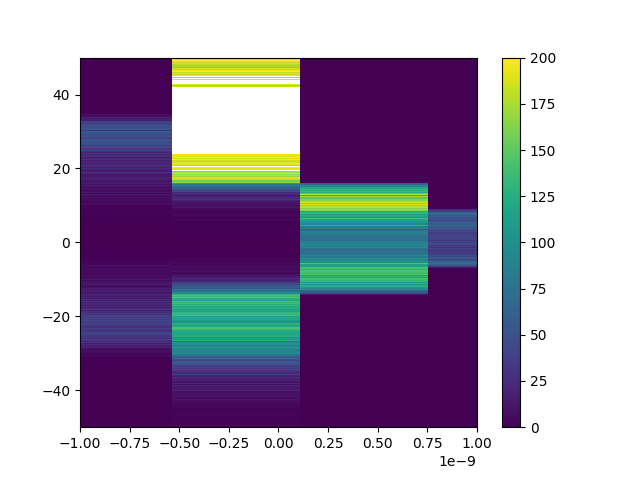

In [28]:
plt.figure()
plt.hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=200)
plt.xlim([-1e-9,1e-9])
plt.ylim([-50,50])
plt.colorbar()

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

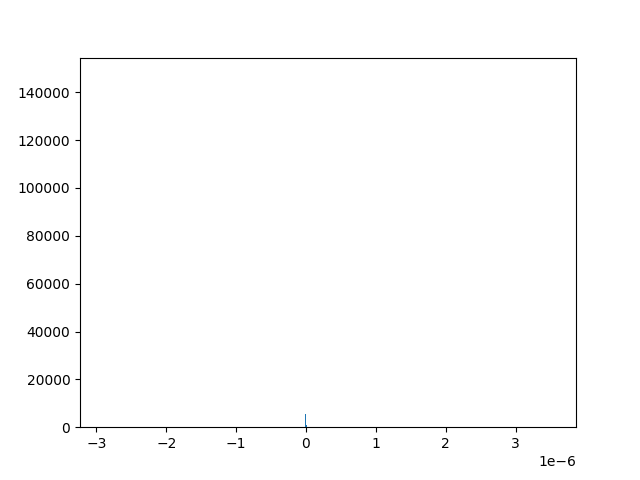

In [25]:
plt.figure()
plt.hist(newcoeffs,bins=1000)

In [26]:
newDistances.shape

(155191, 1)

In [27]:
f.close()